Code to make the plots that will go in the paper.

In [18]:
#%matplotlib qt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('nbagg')
matplotlib.rcParams['figure.dpi'] = 100
%config InlineBackend.figure_format = 'retina'
from scipy.special import expit
from numpy.random import choice 

import datetime


from sunpy.coordinates import sun,frames,ephemeris
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const
from sunpy.sun import constants as con

import sunpy 
import pfsspy


from scipy import integrate
from scipy.optimize import curve_fit

import matplotlib.colors as mcolors
import DL_Drive

import xarray as xr

In [2]:
# read in the crossings and shifts from the hcs_mapping code
fname = 'Matched_crossings_2006_2020.h5'
DL_Drive.DL_Drive(fname)
sec_df = pd.read_hdf(fname)

# Set up some functions #

In [3]:
# calculate the travel time under parker acceleration as derived by nolte
def parker_t(v,r_in=1,r0=0):
    r = 1.5e8*r_in*u.km
    t = r/v
    t_day = 1*t/86400
    
    a= 215
    t_day = (1-(r0/a)**(1-.25))*(4/3)*t_day
#     t_day = (1-(r0/a)**(1-.099))*(4/3)*t_day

    return(t_day*86400)

# simple computation of longitude offset for a travel time
def phi_from_t(t):
    return( (t*con.get('sidereal rotation rate')).to(u.deg) )

In [4]:
def a_calc(v_outer,r_outer,b,n):
    '''function to return the appropriate value of coefficient to reach velocity value of v_outer at radius r_outer,
    in the asymptotic function'''
    return((r_outer.value**n + b)*v_outer/r_outer.value**n )

def parker_angle(r,v):
    '''compute parker spiral angle at distance r for speed v'''
    om = (con.get('sidereal rotation rate')).to(u.rad/u.s)
    return(np.arctan2(r*om,v*u.rad))


In [5]:
def empirical_acc(r,v0,r0,alpha,rh):
    '''this is the HUXt model acceleration'''
    v = v0*( 1 + alpha*(1 - np.exp(-r/rh)*np.exp(r0/rh) ))
    return(v)

def empirical_acc_from_ref(r,r_ref,v_ref,r0,alpha,rh):
    '''This is the HUXt acceleration given v at a different r'''
    v0 = v_ref/( 1+alpha*( 1 - np.exp( (r0-r_ref)/rh ) ) )
    return( empirical_acc(r,v0,r0,alpha,rh) )

def blend_from_emp(r,v_emp,r_cen,r_width):
    # this blends the parker and HUXt model
    i = np.argmin(abs(r_cen - r))
    v_parker = parker_acc(r,v_emp[i],r[i]) 
    
    return(blend_acc(r,v_parker,v_emp,r_cen,r_width))
    

def parker_acc(r,v_ref,r_ref):
    '''Parker fit from Nolte study'''
    K = v_ref/((r_ref)**.25)
    return( K*r**(.25))

def venzmer_acc(r,v0):
    '''acceleration from venzmer+2018'''
    return(v0*(r/(215*u.R_sun))**.099) 

from scipy.interpolate import interp1d

def blend_acc(r,v_inner,v_outer,r_cen,r_width):
    '''generic blender between two v profiles
    one is v_inner and one is v_outer, r_cen is the location of the blend, r_width is the size of the smoothing region
    '''
    a = r < (r_cen-r_width/2)
    b = r > (r_cen+r_width/2)

    ra = r[a]
    va = v_inner[a]
    rb = r[b]
    vb = v_outer[b]

    r_combine = np.concatenate([ra,rb])
    v_combine = np.concatenate([va,vb])

    f = interp1d(r_combine,v_combine,kind='cubic')
    return(f(r))


def vphi_scale(r,vphi,A):
    '''Scale vphi by a factor applied to the angular speed'''
    om = (vphi/r).to(u.deg/u.day)
    Om = (con.get('sidereal rotation rate').to(u.deg/u.day))
    A_scaled=  A*((r[0]/r[-1])/(r/r[-1]))**1.
    coef = A_scaled*(Om-om)
    vphi_scaled = ((coef+om)*r).to(u.km*u.rad/u.s)
    return(vphi_scaled)

def asymp(x, a, b,n):
    '''The asymptotic velocity function from the paper.'''
    return a * (x) ** n  / ((x) ** n + b)


In [6]:
# integrate omega wrt t (details in notebook/paper) to get angular offset caused by weber and davis

def wd_rotation_delta(vphi_in,v,r_in,wd_limit = 1000,r_inner=1.,r_outer=217.): 
    '''vphi_in is vphi, v is vr, r_in is r, wd_limit is where we shut off weber and davis (not used), r_inner and r_outer give integration limits'''
    valid_r_range = (r_in.value > r_inner) & (r_in.value < r_outer) & np.isfinite(vphi_in)
    vphi = vphi_in[valid_r_range]
    r = r_in[valid_r_range]
    v = v[valid_r_range]
    vphi[r>wd_limit*u.R_sun] = 0. # just kill the velocity for that
    delta_phi=integrate.simps( (con.get('sidereal rotation rate').to(u.rad/u.s) - vphi/r.to(u.km))/(v) ,r.to(u.km))*u.rad
    return(delta_phi.to(u.deg))

In [7]:
def wd_calc_eq10(r,vr,ra,va_point):
    '''vphi as computed from equation 10 of weber and davis 1967'''
    om = con.get('sidereal rotation rate') 
    Ma = np.sqrt( vr*r**2/(va_point*ra**2) ) # radial alfven mach number
    return(  ((om*r/va_point)*(va_point-vr)/(1 - (Ma)**2)).to(u.km*u.rad/u.s)  )

def alfven_scale_wd(r,v,ra,va_point): # this is how vA should scale with r from Weber and Davis
    return( (ra/r)*np.sqrt(v*va_point)  )

In [8]:
# define a limitation on valid bins based on the DATA. 

bins = np.linspace(0,360,61)
v,b = np.histogram(sec_df.lon_shift.values,bins=bins) # bin up the longitude shifts

thresh = np.max(v[b[:-1]>=180]) # everything >180 we assume is wrong.
b_upper = np.max(b[1:][v>thresh])
b_lower = np.min(b[:-1][v>thresh])

valid = (sec_df.lon_shift>=b_lower) & (sec_df.lon_shift<=b_upper) # treat the data at >180 as noise, and kill bins below this value

test_df=sec_df.copy()[valid] # this is the data we actually use

In [9]:
# compute dphi from velocity models for each of our HCS crossings

cr_height = 2.5*u.R_sun

r_cen = 20*u.R_sun

r_width = 30*u.R_sun

r = np.linspace(1,215,2000)*u.R_sun

r0 = 30*u.R_sun
rh = 50*u.R_sun
alpha = 0.15


for index,row in test_df.iterrows(): # iterate for each crossing
    r_ind = np.argmin( abs(r-cr_height) ) # find crossing height index
    
    # fill in the travel times
    test_df.loc[index,'parker_t'] = parker_t(row.V*u.km/u.s,r0=cr_height.value).value
    # do the numerical ones:
    v_emp = empirical_acc_from_ref(r,215*u.R_sun,row.V*u.km/u.s,r0,alpha,rh)
    v_venzmer = venzmer_acc(r,row.V)
#     v_blend = 
    v_blend = blend_from_emp(r,v_emp,r_cen,r_width)
    test_df.loc[index,'HUXt_t'] = integrate.simps(1/v_emp[r_ind:],r.to(u.km)[r_ind:])
    test_df.loc[index,'venzmer_t'] = integrate.simps(1/v_venzmer[r_ind:],r.to(u.km)[r_ind:])
    test_df.loc[index,'blend_t'] = integrate.simps(1/v_blend[r_ind:],r.to(u.km)[r_ind:])
    test_df.loc[index,'con_t'] = ((r[-1]-cr_height).to(u.km)/row.V).value
# convert those to longitude shifts:
test_df['parker_dphi'] = phi_from_t(test_df.parker_t.values*u.s)
test_df['venzmer_dphi'] = phi_from_t(test_df.venzmer_t.values*u.s)
test_df['HUXt_dphi'] = phi_from_t(test_df.HUXt_t.values*u.s)
test_df['blend_dphi'] = phi_from_t(test_df.blend_t.values*u.s)
test_df['con_dphi'] = phi_from_t(test_df.con_t.values*u.s)

# Start working on the plots #

In [10]:
# update to Nolte and roelof paper

r  = np.linspace(2.5,215,1000)*u.R_sun

#asymptotic parameters 
b = 30
n = .9
v1 = 400
a = a_calc(v1,r[-1],b,n)

# alfven height
ra = 55*u.R_sun
va = asymp(ra.value,a,b,n)*u.km/u.s # alfven speed at alfven height
v = asymp(r.value,a,b,n)*u.km/u.s # speed profile
vphi = wd_calc_eq10(r,v,ra,va) #  compute vphi

# we won't plot it all
r_plot = np.linspace(0,215,500)*u.R_sun
v_plot = asymp(r_plot.value,a,b,n)*u.km/u.s
vphi_plot = wd_calc_eq10(r_plot,v_plot,ra,va)

cuts = np.linspace(5,210,200) # these are distances we compute the mapping out to

inner_lim = r>=2.5*u.R_sun
dphi_wd =  np.array([wd_rotation_delta(vphi,v,r,r_outer=cut).value for cut in cuts ]) # compute dphi by integrating out to the cut value
dphi_acc = np.array([phi_from_t(integrate.simps(1/v[ inner_lim & (r<cut*u.R_sun)],r.to(u.km)[inner_lim & (r<cut*u.R_sun)])*u.s).value for cut in cuts]) # and for vphi = 0

v_con = np.ones(r.size)*v1 # if mapping at constant speed...

dphi_con =  np.array([phi_from_t(integrate.simps(1/v_con[ inner_lim & (r<cut*u.R_sun)],r.to(u.km)[inner_lim & (r<cut*u.R_sun)])*u.s).value for cut in cuts]) # dphi for that
dphi_wd_con = np.array([wd_rotation_delta(vphi,v_con,r,r_outer=cut).value for cut in cuts ]) # dphi for that but also with vphi non-zero

# append 0 point to all of these
cuts = np.append(0,cuts) 
dphi_wd = np.append(dphi_wd[0],dphi_wd)
dphi_wd_con = np.append(dphi_wd_con[0],dphi_wd_con)
dphi_acc = np.append(dphi_acc[0],dphi_acc)
dphi_con = np.append(dphi_con[0],dphi_con)

#some lines
corot_height = 25
inner_rot = 2.5
outer_rot = 60


# boring plotting code..
ylab = -1.5
fig = plt.figure(constrained_layout=True,figsize = (11.8,3.6))
npanel = 8
xlow = -8
gs = fig.add_gridspec(1, npanel)
ax=fig.add_subplot(gs[ :, 0:(npanel-3)])
plt.plot( [80+dphi_wd[0]- dphi_wd[-1],80+dphi_wd[0]- dphi_wd[-1]] ,[0,corot_height],color='k',lw=1,alpha=.6)
plt.plot(80+dphi_wd - dphi_wd[-1],cuts, label = '$v_r = v_{r}(r)$, $v_{\phi}=v_{\phi}(r)$',color='C1')
plt.plot(80+dphi_acc - (dphi_acc)[-1],cuts,'--', label = '$v_r = v_{r}(r)$, $v_{\phi}=0$',color = 'C1')
plt.plot(80+dphi_wd_con - dphi_wd_con[-1],cuts, label = '$v_r = v_{sc}$, $v_{\phi}=v_{\phi}(r)$',color = 'C0')
plt.plot(80+dphi_con-dphi_con[-1],cuts,'--',label = '$v_r = v_{sc}$, $v_{\phi}=0$',color='C0')
plt.legend(fontsize=10)
plt.ylim(0,210)
plt.xlabel('$\\leftarrow \phi$')
plt.ylabel('$r \\rightarrow$')
plt.xlim([xlow,90])
plt.xticks([])
plt.yticks([])
plt.annotate('(a)',xy = [84.5,190],fontsize=18)


plt.axhspan(inner_rot,outer_rot,color='k',alpha=.07)
# ax.set_yticklabels(['Sun', 'S/C'])
plt.axvline(80,color='k',alpha=.5,ls=':')
plt.axhline(corot_height,color='k',alpha=.5,ls=':')

plt.annotate('Effective corotation height',xy= [53,corot_height],xytext=[53,corot_height+20],arrowprops=dict(facecolor='grey', arrowstyle="->"),horizontalalignment='center')
plt.annotate('$v_r(r)$',xy=[46,100],xytext=[43,120],arrowprops=dict(facecolor='grey', arrowstyle="->"),horizontalalignment='right',verticalalignment = 'top')
plt.annotate('$v_{r, sc}$',xy=[47,90],xytext=[53,70],arrowprops=dict(facecolor='grey', arrowstyle="->"),horizontalalignment='left',verticalalignment = 'center',clip_on=True)
plt.annotate('$\phi_{sc}$',xy=[81,2.5],xytext=[81,ylab],horizontalalignment='center',verticalalignment = 'top')
plt.annotate('$\phi_{\mathrm{A, R}}$',xy=[80+dphi_wd[0]- dphi_wd[-1],2.5],xytext=[80+dphi_wd[0]- dphi_wd[-1],ylab],horizontalalignment='center',verticalalignment = 'top')
plt.annotate('$\phi_{\mathrm{A}}$',xy=[80+dphi_acc[0]- dphi_acc[-1],2.5],xytext=[80+dphi_acc[0]- dphi_acc[-1],ylab],horizontalalignment='center',verticalalignment = 'top')
plt.annotate('$\phi_{\mathrm{C}}$',xy=[21.5,2.5],xytext=[21.5,ylab],horizontalalignment='center',verticalalignment = 'top')
plt.annotate('$\phi_{\mathrm{C, R}}$',xy=[80+dphi_wd_con[0]- dphi_wd_con[-1],2.5],xytext=[80+dphi_wd_con[0]- dphi_wd_con[-1],ylab],horizontalalignment='center',verticalalignment = 'top')
plt.annotate('$Sun$',xy=[xlow,2.5],xytext=[xlow,0],horizontalalignment='right',verticalalignment = 'top')
plt.annotate('$S/C$',xy=[xlow,210],xytext=[xlow,211],horizontalalignment='right',verticalalignment = 'bottom')
ax.annotate('', xy=(xlow, inner_rot), xycoords='data',
            xytext=(xlow, outer_rot), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="bar",
                            ec="k",
                            shrinkA=5, shrinkB=5))
plt.annotate('\'release zone\'',xy=[xlow,21],xytext=[xlow-5,31],rotation=90,horizontalalignment='center',verticalalignment = 'center')



fig.add_subplot(gs[ :, npanel-3])
plt.plot(v_con[-1]*v_plot/v_plot,r_plot,label='$v_{sc}$')
plt.plot(v_plot,r_plot,label='$v(r)$')
plt.xticks([])
plt.yticks([])
plt.ylim(0,210)
plt.xlim(-10,600)
plt.axhspan(inner_rot,outer_rot,color='k',alpha=.07)
plt.axhline(corot_height,color='k',alpha=.5,ls=':')
plt.xlabel('$v_r \\rightarrow$')
plt.annotate('$0$',xy=[0,2.5],xytext=[0,ylab],horizontalalignment='center',verticalalignment = 'top')

plt.annotate('$v_{r, sc}$',xy=[500,90],horizontalalignment='center',verticalalignment = 'center')
plt.annotate('$v_r(r)$',xy=[180,70],horizontalalignment='center',verticalalignment = 'center')
plt.annotate('(b)',xy = [35,190],fontsize=18)


fig.add_subplot(gs[ :, npanel-2])
plt.plot(vphi_plot,r_plot,color='k')
plt.plot(vphi_plot*0,r_plot,'--',color='k')
plt.xlabel('$ v_{\phi} \\rightarrow $')
plt.xticks([])
plt.yticks([])
plt.ylim(0,210)
plt.axhspan(inner_rot,outer_rot,color='k',alpha=.07)
plt.axhline(corot_height,color='k',alpha=.5,ls=':')
plt.annotate('$0$',xy=[0,2.5],xytext=[0,ylab],horizontalalignment='center',verticalalignment = 'top')
plt.annotate('$v_{\phi}(r)$',xy=[9.,115],horizontalalignment='center',verticalalignment = 'center')
plt.annotate('(c)',xy = [12.2,190],fontsize=18)


fig.add_subplot(gs[ :, npanel-1])
plt.plot((vphi_plot/r_plot).to(u.rad/u.s),r_plot,color='k')
plt.plot(vphi_plot*0/r_plot,r_plot,color='k',ls='--')
plt.axvline(con.get('sidereal rotation rate').to(u.rad/u.s).value,color='C3',ls='-.',alpha=.7)
plt.xlabel('$\omega \\rightarrow$')
plt.xticks([])
plt.yticks([])
plt.ylim(0,210)
plt.axhspan(inner_rot,outer_rot,color='k',alpha=.07)
plt.axhline(corot_height,color='k',alpha=.5,ls=':')
plt.annotate('$0$',xy=[0,2.5],xytext=[0,ylab],horizontalalignment='center',verticalalignment = 'top')
plt.annotate('$\Omega$',xy=[con.get('sidereal rotation rate').to(u.rad/u.s).value,2.5],xytext=[con.get('sidereal rotation rate').to(u.rad/u.s).value,ylab],horizontalalignment='center',verticalalignment = 'top')
plt.annotate('$\omega_{\phi}(r)$',xy=[8e-7,40],horizontalalignment='left',verticalalignment = 'center')
plt.annotate('(d)',xy = [16e-7,190],fontsize=18)

plt.savefig('NR_Update.pdf')


<IPython.core.display.Javascript object>

/home/allan/miniconda3/envs/heliomap/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/allan/miniconda3/envs/heliomap/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/allan/miniconda3/envs/heliomap/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [11]:
# setup for the boxplot. Loop over different effective corotation heights and compute the distribution of dphi for each of those

# set up that stuff
r_cen = 30*u.R_sun

r_width = 30*u.R_sun

cr_heights = np.append(np.array(2.5)*u.R_sun,np.linspace(5,45,5)*u.R_sun)

HUXt_ts = np.zeros([cr_heights.size,test_df.shape[0]])*np.nan
blend_ts = HUXt_ts*np.nan
con_ts = HUXt_ts*np.nan
parker_ts = HUXt_ts*np.nan 
venzmer_ts = HUXt_ts*np.nan

# do the loops and calculate travel times
for i,cr_height in enumerate(cr_heights):
    for j,(index,row) in enumerate(test_df.iterrows()):
        r_ind = np.argmin( abs(r-cr_height) )
        parker_ts[i,j] = parker_t(row.V*u.km/u.s,r0=cr_height.value).value
        v_emp = empirical_acc_from_ref(r,215*u.R_sun,row.V*u.km/u.s,r0,alpha,rh)
        v_blend = blend_from_emp(r,v_emp,r_cen,r_width)
        v_venzmer = row.V*u.km/u.s*(r/215*u.R_sun)**.099
        HUXt_ts[i,j]  = integrate.simps(1/v_emp[r_ind:],r.to(u.km)[r_ind:])
        blend_ts[i,j]  = integrate.simps(1/v_blend[r_ind:],r.to(u.km)[r_ind:])
        con_ts[i,j] = ((r[-1]-cr_height).to(u.km)/row.V).value
        venzmer_ts[i,j] = integrate.simps(1/v_venzmer[r_ind:],r.to(u.km)[r_ind:])
# convert to longitudes
parker_dphis = phi_from_t(parker_ts*u.s)
HUXt_dphis = phi_from_t(HUXt_ts*u.s)
blend_dphis = phi_from_t(blend_ts*u.s)
con_dphis = phi_from_t(con_ts*u.s)
venzmer_dphis = phi_from_t(venzmer_ts*u.s)

# compute residuals with the crossing offsets
parker_res =   parker_dphis.value - test_df.lon_shift.values
HUXt_res =   HUXt_dphis.value -  test_df.lon_shift.values
blend_res =   blend_dphis.value - test_df.lon_shift.values
con_res =   con_dphis.value - test_df.lon_shift.values
venzmer_res =   venzmer_dphis.value - test_df.lon_shift.values

# use linear interpolation to find the crossing point
parker_r_0 = np.interp(0,np.nanmean(parker_res,axis=1)[np.argsort(np.nanmean(parker_res,axis=1))],cr_heights[np.argsort(np.nanmean(parker_res,axis=1))])
HUXt_r_0 = np.interp(0,np.nanmean(HUXt_res,axis=1)[np.argsort(np.nanmean(HUXt_res,axis=1))],cr_heights[np.argsort(np.nanmean(HUXt_res,axis=1))])
blend_r_0 = np.interp(0,np.nanmean(blend_res,axis=1)[np.argsort(np.nanmean(blend_res,axis=1))],cr_heights[np.argsort(np.nanmean(blend_res,axis=1))])
con_r_0 = np.interp(0,np.nanmean(con_res,axis=1)[np.argsort(np.nanmean(con_res,axis=1))],cr_heights[np.argsort(np.nanmean(con_res,axis=1))])
venzmer_r_0 = np.interp(0,np.nanmean(venzmer_res,axis=1)[np.argsort(np.nanmean(venzmer_res,axis=1))],cr_heights[np.argsort(np.nanmean(venzmer_res,axis=1))])


In [12]:
# Boxplot for the paper. This is basically plotting code

plt.figure(figsize=(5,5))

labs  = np.array([f'{height:.0f}' for height in cr_heights.value[1:] ])

labs[1::2] = ''
ylim= 60
blanklabs = ['']*len(labs)

ax = plt.subplot(221)
plt.axhline(0,color='k',alpha=0.4)
ax.boxplot(con_res[1:].T,labels =blanklabs,medianprops=dict(color='C0'))
plt.title('Constant v')
plt.ylabel('$\Delta\phi - \Delta\phi_{\mathrm{HCS}}$ ($^{\circ}$)')
plt.ylim(-ylim,ylim)
ax = plt.subplot(222)
plt.axhline(0,color='k',alpha=0.4)
ax.boxplot(parker_res[1:].T,labels =blanklabs,medianprops=dict(color='C1'))
plt.title('Parker')
plt.ylim(-ylim,ylim)
ax = plt.subplot(223)
plt.axhline(0,color='k',alpha=0.4)
# ax.boxplot(HUXt_res[1:].T,labels =labs)
# plt.title('HUXt')
ax.boxplot(venzmer_res[1:].T,labels =labs,medianprops=dict(color='C2'))
plt.title('VB18')
plt.ylabel('$\Delta\phi - \Delta\phi_{\mathrm{HCS}}$  ($^{\circ}$)')
plt.ylim(-ylim,ylim)
plt.xticks(rotation=45)
plt.xlabel('$r_{\mathrm{EC}}$ (R$_{\odot}$)')

ax = plt.subplot(224)
plt.axhline(0,color='k',alpha=0.4)
ax.boxplot(blend_res[1:].T,labels =labs,medianprops=dict(color='C4'))
plt.title('Blended')
plt.ylim(-ylim,ylim)
plt.xticks(rotation=45)
plt.xlabel('$r_{\mathrm{EC}}$ (R$_{\odot}$)')

plt.tight_layout()

plt.savefig('corot_height_boxplot.pdf')

<IPython.core.display.Javascript object>

In [13]:
# obtain histograms for optimal case for these velocity profiles, base on above crossings. Basically the same as 2 cells up

HUXt_r_ind = np.argmin( abs(r-HUXt_r_0) )
parker_r_ind = np.argmin( abs(r-parker_r_0) )
venzmer_r_ind = np.argmin( abs(r-venzmer_r_0) )
con_r_ind = np.argmin( abs(r-con_r_0) )
blend_r_ind = np.argmin( abs(r-blend_r_0) )


HUXt_opt_ts = np.zeros(test_df.V.size)
parker_opt_ts = np.zeros(test_df.V.size)
blend_opt_ts = np.zeros(test_df.V.size)
con_opt_ts = np.zeros(test_df.V.size)
venzmer_opt_ts = np.zeros(test_df.V.size)


for j,(index,row) in enumerate(test_df.iterrows()):
    parker_opt_ts[j] = parker_t(row.V*u.km/u.s,r0=parker_r_0.value).value

#         # do the numerical ones:
    v_emp = empirical_acc_from_ref(r,215*u.R_sun,row.V*u.km/u.s,r0,alpha,rh)
    v_blend = blend_from_emp(r,v_emp,r_cen,r_width)
    v_venzmer = venzmer_acc(r,row.V*u.km/u.s)

    HUXt_opt_ts[j]  = integrate.simps(1/v_emp[HUXt_r_ind:],r.to(u.km)[HUXt_r_ind:])
    blend_opt_ts[j]  = integrate.simps(1/v_blend[blend_r_ind:],r.to(u.km)[blend_r_ind:])
    venzmer_opt_ts[j] = integrate.simps(1/v_venzmer[venzmer_r_ind:],r.to(u.km)[venzmer_r_ind:])
    con_opt_ts[j] = ((r[-1]-con_r_0).to(u.km)/row.V).value
    
parker_opt_dphis = phi_from_t(parker_opt_ts*u.s)
HUXt_opt_dphis = phi_from_t(HUXt_opt_ts*u.s)
blend_opt_dphis = phi_from_t(blend_opt_ts*u.s)
con_opt_dphis = phi_from_t(con_opt_ts*u.s)
venzmer_opt_dphis = phi_from_t(venzmer_opt_ts*u.s)

parker_opt_res =   parker_opt_dphis.value -test_df.lon_shift.values
HUXt_opt_res =  HUXt_opt_dphis.value - test_df.lon_shift.values
blend_opt_res =   blend_opt_dphis.value -test_df.lon_shift.values
con_opt_res =   con_opt_dphis.value -test_df.lon_shift.values
venzmer_opt_res =   venzmer_opt_dphis.value -test_df.lon_shift.values



In [14]:
# Histogram plot for the paper

bwidth = 10
bins= np.arange(20,120+bwidth,bwidth)

plt.figure(figsize=(10,2.5))

ax=plt.subplot(142)
# plt.title(f'Corotation at {cr_height.value}'+' R$_{\odot}$')
plt.hist(test_df.con_dphi,density=True,label='Const',histtype='step',bins=bins)
plt.hist(test_df.parker_dphi,histtype='step',density=True,label='Parker',bins=bins)
plt.hist(test_df.venzmer_dphi,histtype='step',density=True,label='VB18',bins=bins)
plt.hist(test_df.HUXt_dphi,density=True,histtype='step',label = 'HUXt',bins=bins)
plt.hist(test_df.blend_dphi,density=True,histtype='step',label = 'Blend',bins=bins)
plt.hist(test_df.lon_shift,density=True,label='Data',color='k',alpha=.2,bins=bins)
plt.legend(prop={'size': 8},loc=2,framealpha=.65)
plt.xlabel('$\Delta\phi$ ($^{\circ}$)')
plt.title('Mapping Predictions')
plt.xlim([-5,125])
# plt.xticks([0,45,90])
plt.annotate('(b)',xy = [.85,.87],fontsize=12,xycoords = 'axes fraction')

plt.subplot(141)
plt.hist(sec_df.lon_shift,label='Full Data',histtype='step',bins=np.linspace(0,360,37),color='tab:cyan')
plt.hist(test_df.lon_shift,label='Reduced Data',color='k',alpha=.4,bins=np.linspace(0,360,37))
plt.xlabel('$\Delta\phi_{\mathrm{HCS}}$ ($^{\circ}$)')
leg = plt.legend(prop={'size': 8})
plt.xticks([0,90,180,270,360])
plt.title('HCS Crossing Offsets')
plt.annotate('(a)',xy = [.03,.87],fontsize=12,xycoords = 'axes fraction')


bins = np.arange(-60,70+bwidth,bwidth)

plt.subplot(143)
# plt.title('Residuals')
plt.hist(test_df.con_dphi-test_df.lon_shift,histtype='step',density=True,label=f'{np.nanmean(test_df.con_dphi-test_df.lon_shift):.1f}, {np.nanstd(test_df.con_dphi-test_df.lon_shift):.1f}',bins=bins)
plt.hist(test_df.parker_dphi-test_df.lon_shift,histtype='step',density=True,label=f'{np.nanmean(test_df.parker_dphi-test_df.lon_shift):.1f}, {np.nanstd(test_df.parker_dphi-test_df.lon_shift):.1f}',bins=bins)
plt.hist(test_df.venzmer_dphi-test_df.lon_shift,histtype='step',density=True,label=f'{np.nanmean(test_df.venzmer_dphi-test_df.lon_shift):.1f}, {np.nanstd(test_df.venzmer_dphi-test_df.lon_shift):.1f}',bins=bins)
plt.hist(test_df.HUXt_dphi-test_df.lon_shift,density=True,histtype='step',label = f'{np.nanmean(test_df.HUXt_dphi-test_df.lon_shift):.1f}, {np.nanstd(test_df.HUXt_dphi-test_df.lon_shift):.1f}',bins=bins)
plt.hist(test_df.blend_dphi-test_df.lon_shift,density=True,histtype='step',label = f'{np.nanmean(test_df.blend_dphi-test_df.lon_shift):.1f}, {np.nanstd(test_df.blend_dphi-test_df.lon_shift):.1f}',bins=bins)
leg=plt.legend(title='$\mu$, $\sigma$ ($^{\circ}$)',prop={'size': 8},loc=2,framealpha=.65)
plt.xlabel('$\Delta\phi_M - \Delta\phi_{\mathrm{HCS}}$ ($^{\circ}$)')
plt.xlim([bins[0]-55,bins[-1]+5])
plt.title('Residuals')
leg.get_title().set_fontsize('8') #legend 'Title' fontsize
plt.annotate('(c)',xy = [.85,.87],fontsize=12,xycoords = 'axes fraction')


plt.subplot(144)
# plt.title('Residuals')
plt.hist(con_opt_res,histtype='step',density=True,label=f'{np.nanmean(con_opt_res):.1f}, {np.nanstd(con_opt_res):.1f}',bins=bins)
plt.hist(parker_opt_res,histtype='step',density=True,label=f'{np.nanmean(parker_opt_res):.1f}, {np.nanstd(parker_opt_res):.1f}',bins=bins)
plt.hist(venzmer_opt_res,histtype='step',density=True,label=f'{np.nanmean(venzmer_opt_res):.1f}, {np.nanstd(venzmer_opt_res):.1f}',bins=bins)
plt.hist(HUXt_opt_res,density=True,histtype='step',label = f'{np.nanmean(HUXt_opt_res):.1f}, {np.nanstd(HUXt_opt_res):.1f}',bins=bins)
plt.hist(blend_opt_res,density=True,histtype='step',label = f'{np.nanmean(blend_opt_res):.1f}, {np.nanstd(blend_opt_res):.1f}',bins=bins)
leg=plt.legend(title='$\mu$, $\sigma$ ($^{\circ}$)',prop={'size': 8},framealpha=.65,loc=2)
plt.xlabel('$\Delta\phi_M - \Delta\phi_{\mathrm{HCS}}$ ($^{\circ}$)')
plt.xlim([bins[0]-55,bins[-1]+5])
plt.title('Optimal $r_{\mathrm{EC}}$')
leg.get_title().set_fontsize('8') #legend 'Title' fontsize
plt.annotate('(d)',xy = [.85,.87],fontsize=12,xycoords = 'axes fraction')

plt.tight_layout()
plt.savefig('dphi_histograms.pdf')



<IPython.core.display.Javascript object>

In [15]:
# Plot some example profiles of velocity 

# more setup...

# stuff for asymptotic profile
asym_factors = np.exp(np.linspace(np.log(.5),np.log(30),8))

n_use = 0.8

# for HUXt profile
r0 = 30*u.R_sun
rh = 50*u.R_sun
v0 = 340*u.km/u.s
alpha = 0.15
r_start= 2.5
v_emp = empirical_acc(r,v0,r0,alpha,rh)

#blend 
r_switch=30*u.R_sun
i = np.argmin(abs(r_switch - r))
v_parker = parker_acc(r,v_emp[i],r[i]) 
v_blend = blend_acc(r,v_parker,v_emp,30*u.R_sun,30*u.R_sun)

# other stuff
v_parker = parker_acc(r,v_emp[-1],r[-1]) 
v_con = v_emp[-1]*v_parker/v_parker
v_venzmer = venzmer_acc(r,v_emp[-1])

# and plot it
plt.figure(figsize=(3.5,5.3))

plt.subplot(211)

plt.plot(r,v_con,label = 'Const.')
plt.plot(r,v_parker,label='Parker fit')
plt.plot(r,v_venzmer,label='VB18')
plt.plot(r,v_emp,label = 'HUXt')
plt.plot(r,v_blend,label='Blend')
plt.xlabel('$r$ ($R_{\odot}$)')
plt.ylabel('$v_r$ (km/s)')
plt.legend(title='Models',fontsize=9)
plt.title('Velocity Profiles')

cmap = plt.get_cmap('cividis')

plt.subplot(212)
for j,val in enumerate(asym_factors): # loop for different velocity profiles
    p = [0,0,n_use]
    v=400
    p[1] = val
    p[0] = (r[-1].value**p[2] + p[1])*v/r[-1].value**p[2]
    v_asymp = asymp(r.value,*p)
    plt.plot(r,v_asymp,label= f'{val:.1f}',color=cmap( j/(asym_factors.size -1) ) )
    plt.ylabel('v')
    plt.xlabel('$r$ ($R_{\odot}$)')
plt.title('Empirical Profiles, $n = 0.8$')
plt.legend(title = '$b$',ncol=2,fontsize=9)
plt.tight_layout(rect=[0, 0.0, .8, 1])
plt.savefig('example_v_profiles.pdf')

<IPython.core.display.Javascript object>

In [19]:
# This is the set of values that the main heatmap results come from. We loop through n and b, and for each crossing, compute the delta phi value

# This takes a long time to run so I have the result pre-saved in dphi_4d_systematic_vphi_update.pickle which will PROBABLY NOT OPEN on other machines

savethis = False # if we're saving a new result make true
runthis = False # if we're creating a new result make true
loadthis = True # if we're loading an old result make true

# the ranges of parameters we're looping
r_a_vals = np.linspace(5,75,25)*u.R_sun
b_vals= np.exp(np.linspace(np.log(.1),np.log(40),40))
n_vals = (np.linspace(.3,2,8))
r = np.linspace(0,215,2000)*u.R_sun

cut = 215

# set up arrays to write to
dphi_4d_array = np.zeros([r_a_vals.size,n_vals.size,b_vals.size, test_df.V.size] )

if runthis:
    for i,r_a_val in enumerate(r_a_vals):
        for j,n_val in enumerate(n_vals):
            for k,b_val in enumerate(b_vals):
                for l,(index,row) in enumerate(test_df.iterrows()):
                    r_ind = np.argmin( abs(r-cr_height) )
                    a = a_calc(row.V*u.km/u.s,215*u.R_sun,b_val,n_val)
                    p = [a,b_val,n_val]
                    v_profile = asymp(r.value,*p)

                    v_point = asymp(r_a_val.value,*p)
                    v_a_point = v_point*1.
                    vphi = wd_calc_eq10(r,v_profile,r_a_val,v_a_point)
                    
                    dphi_4d_array[i,j,k,l] = wd_rotation_delta(vphi,v_profile,r,wd_limit=cut).value # compute the mapping

fname = 'dphi_4d_array.nc'

if savethis: # use xarray since it's high dimensional
    ds = xr.Dataset(data_vars={'dphi':(('ra','n','b','hcs'),dphi_4d_array)},coords= {'ra':('ra',r_a_vals),'n':('n',n_vals),'b':('b',b_vals),'lonshift':('hcs',test_df.lon_shift.values)}) 
    ds.to_netcdf(fname)
    
# here's one I made earlier....
if loadthis:
    DL_Drive.DL_Drive(fname)# download it if I don't have it already
    ds = xr.open_dataset(fname)
    dphi_4d_array = ds.dphi.values
    r_a_vals = ds.ra.values*u.R_sun
    b_vals = ds.b.values
    n_vals = ds.n.values


<IPython.core.display.Javascript object>


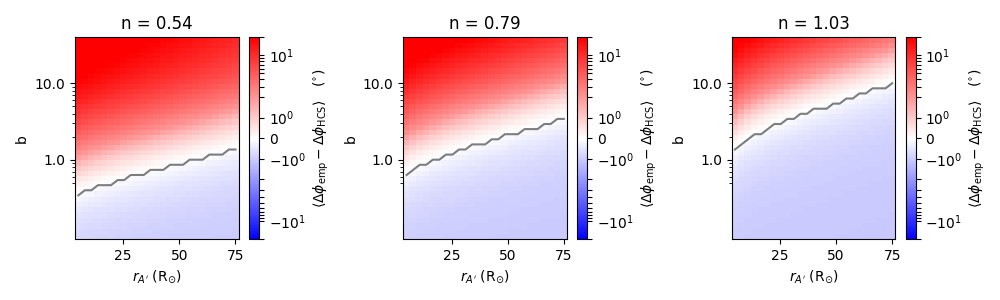

<ipython-input-20-7788a5dbe951>:40: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  plt.pcolormesh(ra_bins,b_bins,dphi_res_mean.T,cmap=plt.get_cmap('bwr'),norm = mcolors.SymLogNorm(linthresh=2),vmin=-20,vmax=20)
<ipython-input-20-7788a5dbe951>:40: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  plt.pcolormesh(ra_bins,b_bins,dphi_res_mean.T,cmap=plt.get_cmap('bwr'),norm = mcolors.SymLogNorm(linthresh=2),vmin=-20,vmax=20)
<ipython-input-20-7788a5dbe951>:40: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  plt.pcolormesh(ra_bins,b_bins,dphi_res_mean.T,cmap=plt.get_cmap('bwr'),norm = mcolors.SymLogNorm(linthresh=2),vmin=-20,vmax=20)


In [20]:
# plot the histogram of mean residual for the paper

from scipy.interpolate import interp2d

# we need to be careful to define our parameter bins...
ra_width = r_a_vals[1]-r_a_vals[0]
ra_bins = r_a_vals - ra_width/2
ra_bins = np.append(ra_bins,ra_bins[-1]+ra_width).value

n_width = n_vals[1]-n_vals[0]
n_bins = n_vals - n_width/2
n_bins = np.append(n_bins,n_bins[-1]+n_width)

b_width = b_vals[1]-(b_vals[0])
b_bins = b_vals - b_width/2
b_bins = np.log(np.append(b_bins,b_bins[-1]+b_width))
b_lin_ticks = np.array([1,10])
b_ticks = np.log( b_lin_ticks )
b_tick_labels = [f'{b:.1f}' for b in b_lin_ticks  ]
b_minor_ticks = np.log(np.hstack([np.linspace(.5,1,6),np.linspace(2,10,9 )] ))


# do the plot
plt.figure(figsize=(10,3))

i_sub = [1,2,3]
n_val_sub = n_vals[i_sub]
j=0
for i,n in zip(i_sub,n_val_sub):
    j+=1
    dphi_residual = dphi_4d_array[:,i,:] - test_df.lon_shift.values[np.newaxis,np.newaxis,:] 
    dphi_res_mean = np.nanmean((dphi_residual),axis=2)

    dphi_absres_mean = np.nanmean(abs(dphi_residual),axis=2) # doing the mean
    min_inds = np.argmin(abs(dphi_res_mean),axis=1) 
    min_b = np.log(np.array([ b_vals[i] for i in min_inds ])) # compute line of bin of minimum residual

    ax=plt.subplot(1,3,j)
    plt.title(f'n = {n:.2f}')
    plt.pcolormesh(ra_bins,b_bins,dphi_res_mean.T,cmap=plt.get_cmap('bwr'),norm = mcolors.SymLogNorm(linthresh=2),vmin=-20,vmax=20)
    plt.colorbar(label=r'$\langle \Delta \phi_{\mathrm{emp}} -\Delta \phi_{\mathrm{HCS}}   \rangle$   ($^{\circ}$)')
    plt.xlabel(r"$r_{A'}$ (R$_{\odot})$")
    ax.set_yticks(b_ticks)
    ax.set_yticklabels( b_tick_labels)
    ax.set_yticks(b_minor_ticks,minor=True )
    plt.ylabel('b')
    plt.plot(r_a_vals,min_b,color='k',alpha=.5)
    
    
plt.tight_layout()
plt.savefig('b_n_ra_mean_heatmaps.pdf')

<IPython.core.display.Javascript object>


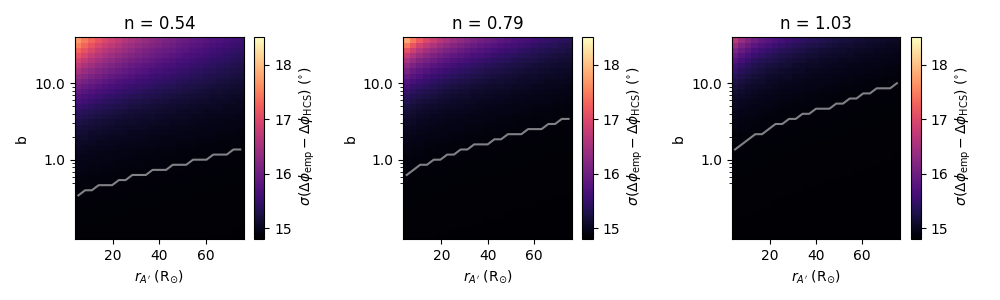

In [23]:
# this is the same plot but for the standard deviation

plt.figure(figsize=(10,3))

i_sub = [1,2,3]
n_val_sub = n_vals[i_sub]

j=0
for i,n in zip(i_sub,n_val_sub):
    j+=1
    dphi_residual =dphi_4d_array[:,i,:] - test_df.lon_shift.values[np.newaxis,np.newaxis,:] 
    dphi_res_mean = np.nanmean((dphi_residual),axis=2)

    dphi_absres_mean = np.nanmean(abs(dphi_residual),axis=2)
    min_inds = np.argmin(abs(dphi_res_mean),axis=1)
    min_b = np.log(np.array([ b_vals[i] for i in min_inds ]))
    dphi_res_std = np.nanstd((dphi_residual),axis=2)
    
    ax=plt.subplot(1,3,j)
    plt.title(f'n = {n:.2f}')#', best = {np.min(abs(dphi_absres_mean)):.2f}')
    plt.pcolormesh(ra_bins,b_bins,dphi_res_std.T,cmap=plt.get_cmap('magma'),vmin = 14.8,vmax=18.5)
    plt.colorbar(label=r' $\sigma (\Delta \phi_{\mathrm{emp}} -\Delta \phi_{\mathrm{HCS}}  )$ ($^{\circ}$)')
    plt.xlabel(r"$r_{A'}$ (R$_{\odot})$")
    plt.ylabel('b')
    ax.set_yticks(b_ticks)
    ax.set_yticklabels( b_tick_labels)
    ax.set_yticks(b_minor_ticks,minor=True )
    ax.plot(r_a_vals,min_b,color='w',alpha=.5)
    
plt.tight_layout()
plt.savefig('b_n_ra_std_heatmaps.pdf')

<IPython.core.display.Javascript object>


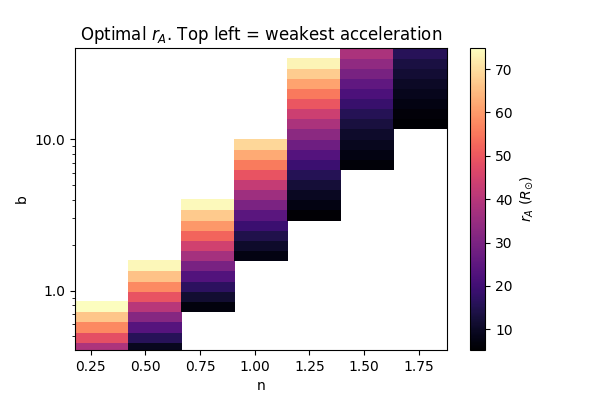

In [24]:
# plot of the 'optimal' value for rA for each b and n from above

dphi_residual = dphi_4d_array[:,:] - test_df.lon_shift.values[np.newaxis,np.newaxis,:] 
dphi_res_mean = np.nanmean((dphi_residual),axis=3)

# find smooth minimum by interpolation now
r_a_0 =np.array([ [ interp1d(dphi_res_mean[:,j,k],r_a_vals.value,bounds_error=False,fill_value=np.nan)(0) for k,b_val in enumerate(b_vals)] for j,n in enumerate(n_vals)] ) 

import matplotlib as mpl
cmap = plt.get_cmap('magma')
bounds = ra_bins
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure()
ax=plt.subplot(111)
plt.pcolormesh(n_bins,b_bins,r_a_0.T,cmap=cmap)
plt.colorbar(label='$r_A$ ($R_{\odot}$)')
ax.set_yticks(b_ticks)
ax.set_yticklabels( b_tick_labels)
ax.set_yticks(b_minor_ticks,minor=True )

plt.xlabel('n')
plt.ylabel('b')
plt.xlim([n_bins[0],n_bins[-2]])
plt.ylim(-.9,b_bins[-1])
plt.title('Optimal $r_A$. Top left = weakest acceleration')
plt.savefig('optimal_rA_plot.pdf')

<IPython.core.display.Javascript object>


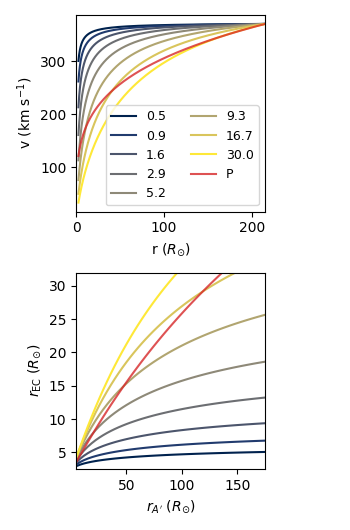

In [25]:
# Plot for paper of how does effective height relate to rA?

r = np.linspace(2.5,215,5000)*u.R_sun
r_a_vals = np.linspace(5,175.,50)*u.R_sun
r_innervals =  r[0:700]  
b_vals= np.exp(np.linspace(np.log(.5),np.log(30),8))

vphi_store =np.zeros([r_a_vals.size,r.size] )
dphi_WD_array = np.zeros([r_a_vals.size] )

asymp_v_store =np.zeros([b_vals.size,r.size] )*u.km/u.s
vphi_store_asymp =np.zeros([r_a_vals.size,b_vals.size,r.size] )*u.km*u.rad/u.s
dphi_WD_array_asymp = np.zeros([r_a_vals.size,b_vals.size] )
dphi_cuts_asymp = np.zeros([r_innervals.size,b_vals.size] )


wd_cutoff = 214*u.R_sun

# asymptotic v params
v0 = 370
n = .8
# compute and store v and dphi for those, mapping from different inner locations with no vphi (for effective corotation)
for j,b in enumerate(b_vals):
    a = a_calc(v0*u.km/u.s,215*u.R_sun,b,n)
    asymp_v_store[j] = asymp(r.value,a,b,n)
for i,cut in enumerate(r_innervals):
    for j,b in enumerate(b_vals):
        dphi_cuts_asymp[i,j] = wd_rotation_delta(0*asymp_v_store[j]*u.rad,asymp_v_store[j],r,r_inner=cut.value).value

# loop through different r_a and compute the actual mapping with non-zero vphi
for i,r_a_val in enumerate(r_a_vals):
    v_profile = parker_acc(r.value,v0*u.km/u.s,215)
    v_point = parker_acc(r_a_val.value,v0*u.km/u.s,215)
    v_a_point = v_point*1.
    vphi = wd_calc_eq10(r,v_profile,r_a_val,v_a_point)
    vphi_store[i] = vphi.value
    dphi_WD_array[i] = wd_rotation_delta(vphi,v_profile,r,wd_limit=wd_cutoff.value).value
    
    for j,v_prof2 in enumerate(asymp_v_store): # again looping for different asymptotic v profiles
        a = a_calc(v0*u.km/u.s,215*u.R_sun,b_vals[j],n)
        v_a_point = asymp(r_a_val.value,a.value,b_vals[j],n)*u.km/u.s
        vphi = wd_calc_eq10(r,v_prof2,r_a_val,v_a_point)
        vphi_store_asymp[i,j] = vphi
        dphi_WD_array_asymp[i,j] = wd_rotation_delta(vphi,v_prof2,r,wd_limit=wd_cutoff.value).value

# this is the same as above but just for comparing with the parker plot stuff
v_con = v_profile[-1]
dphi_cuts = r_innervals.value*0
for i,cut in enumerate(r_innervals):
    dphi_cuts[i] = wd_rotation_delta(0*vphi,v_profile,r,r_inner=cut.value).value

# compute the corotation height which best approximates the mapping with non-zero vphi

# for parker fit
best_corot = np.array([ interp1d(dphi_cuts - dphi_rA ,r_innervals.value,bounds_error=False )(0) for dphi_rA in dphi_WD_array  ])

# for all our asymptotic profiles
best_corot_asymp = np.array([ [ interp1d(dphi_cuts - dphi_rA ,r_innervals.value,bounds_error=False )(0) for dphi_rA in dphi_WD] for (dphi_WD,dphi_cuts) in zip(dphi_WD_array_asymp.T,dphi_cuts_asymp.T) ])


# Plot the outcome
cmap = plt.get_cmap('cividis')

plt.figure(figsize = (3.5,5.3))
plt.subplot(211)
# plot these w list comprehension
[plt.plot(r,v_asymp,label = f'{b:.1f}',color=cmap(i/(b_vals.size-1))) for i,(v_asymp,b) in enumerate(zip(asymp_v_store,b_vals))]
plt.plot(r,v_profile,color='C3',alpha=.8,label='P')
plt.legend(fontsize=9,ncol=2)
plt.xlabel('r ($R_{\odot}$)')
plt.ylabel('v (km s$^{-1}$)')
plt.xlim(0,215)

plt.subplot(212)
# and again
[plt.plot(r_a_vals,best_c,color=cmap(i/(b_vals.size-1))) for i,(best_c,b) in enumerate(zip(best_corot_asymp,b_vals) )]
plt.plot(r_a_vals,best_corot,color='C3',alpha=.8)

plt.xlabel(r"$r_{A'}$ ($R_{\odot}$)")
plt.ylabel('$r_{\mathrm{EC}}$ ($R_{\odot}$)')
plt.axhline(2.5,lw=.5,color='k')
plt.xlim(r_a_vals[0].value,r_a_vals[-1].value)
plt.ylim(2.5,32)
plt.tight_layout(rect=[0, 0.0, .8, 1])
plt.savefig('corot_demonstration.pdf')

<IPython.core.display.Javascript object>


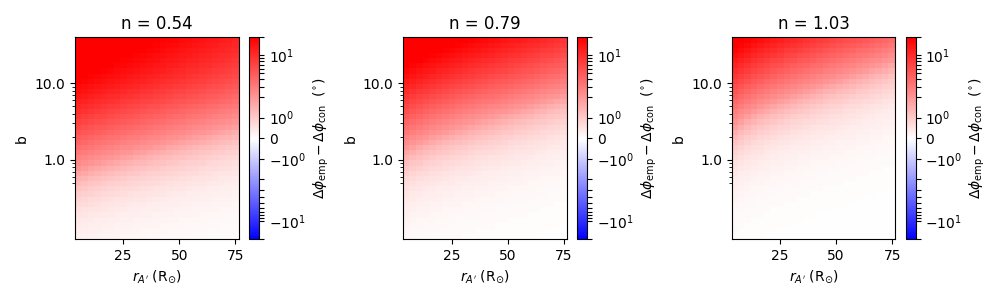

<ipython-input-26-d21349e066ab>:65: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  plt.pcolormesh(ra_bins,b_bins,dphi_res_con[:,i].T,cmap=plt.get_cmap('bwr'),norm = mcolors.SymLogNorm(linthresh=2),vmin=-20,vmax=20)


In [26]:
# Appendix plot regarding the asymptotic stuff

# run for a single speed comparing dphi predictions to dphi_con 

# use the same parameter stuff as the main result plot
r_a_vals = np.linspace(5,75,25)*u.R_sun
b_vals= np.exp(np.linspace(np.log(.1),np.log(40),40))
n_vals = (np.linspace(.3,2,8))

cut = 215
dphi_3d_array = np.zeros([r_a_vals.size,n_vals.size,b_vals.size] )
dphi_3d_array_scaled = np.zeros([r_a_vals.size,n_vals.size,b_vals.size] )

ratio = np.zeros([r_a_vals.size,n_vals.size,b_vals.size] )
v0 = 370*u.km/u.s

for i,r_a_val in enumerate(r_a_vals):
    for j,n_val in enumerate(n_vals):
        for k,b_val in enumerate(b_vals):
            r_ind = np.argmin( abs(r-cr_height) )
            a = a_calc(v0,215*u.R_sun,b_val,n_val)
            p = [a,b_val,n_val]
            v_profile = asymp(r.value,*p)


            v_point = asymp(r_a_val.value,*p)
            v_a_point = v_point*1.

            vphi = wd_calc_eq10(r,v_profile,r_a_val,v_a_point)
            dphi_3d_array[i,j,k] = wd_rotation_delta(vphi,v_profile,r,wd_limit=cut).value
            ratio[i,j,k] = 1 - v_a_point/v_profile[-1]

dphi0 = wd_rotation_delta(vphi*0,v0*r/r,r,wd_limit=cut).value
            
dphi_res_con = dphi_3d_array - dphi0
dphi_res_con_scaled = dphi_3d_array_scaled - dphi0

# set up plotting bins
ra_width = r_a_vals[1]-r_a_vals[0]
ra_bins = r_a_vals - ra_width/2
ra_bins = np.append(ra_bins,ra_bins[-1]+ra_width).value

n_width = n_vals[1]-n_vals[0]
n_bins = n_vals - n_width/2
n_bins = np.append(n_bins,n_bins[-1]+n_width)

b_width = b_vals[1]-(b_vals[0])
b_bins = b_vals - b_width/2
b_bins = np.log(np.append(b_bins,b_bins[-1]+b_width))
b_lin_ticks = np.array([1,10])
b_ticks = np.log( b_lin_ticks )
b_tick_labels = [f'{b:.1f}' for b in b_lin_ticks  ]
b_minor_ticks = np.log(np.hstack([np.linspace(.5,1,6),np.linspace(2,10,9 )] ))

# now plot this
plt.figure(figsize=(10,3))

i_sub = [1,2,3]
n_val_sub = n_vals[i_sub]
j=0
for i,n in zip(i_sub,n_val_sub):
    j+=1
    ax=plt.subplot(1,3,j)
    plt.title(f'n = {n:.2f}')
    plt.pcolormesh(ra_bins,b_bins,dphi_res_con[:,i].T,cmap=plt.get_cmap('bwr'),norm = mcolors.SymLogNorm(linthresh=2),vmin=-20,vmax=20)
    plt.xlabel(r"$r_{A'}$ (R$_{\odot})$")
    ax.set_yticks(b_ticks)
    ax.set_yticklabels( b_tick_labels)
    ax.set_yticks(b_minor_ticks,minor=True )
    plt.ylabel('b')
    plt.colorbar(label='$\Delta \phi_{\mathrm{emp}} - \Delta \phi_{\mathrm{con}} $  ($^{\circ}$)')
plt.tight_layout()

plt.savefig('empirical_con_res_heatmap.pdf')

<IPython.core.display.Javascript object>


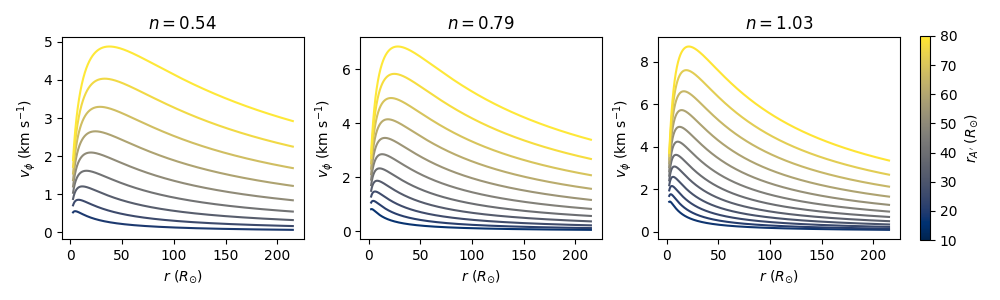

In [27]:
# plot of example vphi for the optimal rA b n combinations

import matplotlib.colors as colors
b_inds = np.arange(0,b_vals.size)
n_inds =i_sub
cmap= plt.get_cmap('cividis')

n_val_sub = n_vals[i_sub]

fig,axes = plt.subplots(nrows=1, ncols=3,figsize=(10,3))
k=0
for j,n in zip(n_inds,n_vals[n_inds]):
    for i,b in enumerate(b_vals[b_inds]):
        r_a = r_a_0[j,i]
        if np.isfinite(r_a):
            a = a_calc(370*u.km/u.s,215*u.R_sun,b,n)
            v_r = asymp(r.value,a,b,n)
            v_a_point = asymp(r_a,a,b,n)
            v_phi = wd_calc_eq10(r,v_r,r_a*u.R_sun,v_a_point)
            axes.flatten()[k].plot(r,v_phi,color = cmap(r_a/70. ))

    k+=1

[ax.set_xlabel('$r$ ($R_{\odot}$)') for ax in axes]
[ax.set_ylabel('$v_{\phi}$ (km s$^{-1}$)') for ax in axes]
[ax.set_title(f'$n =${n:.2f}') for n,ax in zip(n_val_sub,axes.flatten())]

plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.2, 0.01, 0.68])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=colors.Normalize(vmin=10, vmax=80))
fig.colorbar(sm,label = "$r_{A'}$ ($R_{\odot}$)",cax=cbar_ax)
plt.savefig('vphi_opt_examples.pdf')

<IPython.core.display.Javascript object>


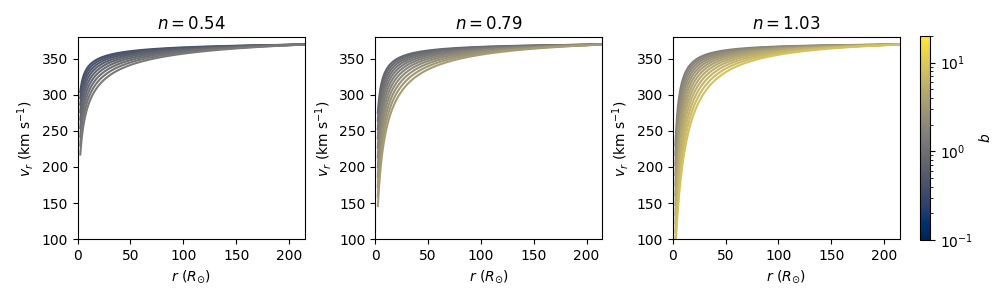

In [28]:
# plot of example vr for the optimal rA b n combinations

fig,axes = plt.subplots(nrows=1, ncols=3,figsize=(10,3))
k=0
for j,n in zip(n_inds,n_vals[n_inds]):
    for i,b in enumerate(b_vals[b_inds]):
        r_a = r_a_0[j,i]
        if np.isfinite(r_a):
            a = a_calc(370*u.km/u.s,215*u.R_sun,b,n)
            v_r = asymp(r.value,a,b,n)
            axes.flatten()[k].plot(r,v_r,color = cmap( (np.log(b)- np.log(min(b_vals)))/(np.log(20) - np.log(np.min(b_vals))) ))
    k+=1

[ax.set_xlabel('$r$ ($R_{\odot}$)') for ax in axes]
[ax.set_ylabel('$v_{r}$ (km s$^{-1}$)') for ax in axes]
[ax.set_title(f'$n =${n:.2f}') for n,ax in zip(n_vals[n_inds],axes.flatten())]
[ax.set_ylim([100,380]) for ax in axes.flatten()]
[ax.set_xlim([0,215]) for ax in axes.flatten()]

plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.2, 0.01, 0.68])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=colors.LogNorm(vmin=b_vals[0], vmax=20))
fig.colorbar(sm,label = '$b$',cax=cbar_ax)
plt.savefig('vr_opt_examples.pdf')

<IPython.core.display.Javascript object>


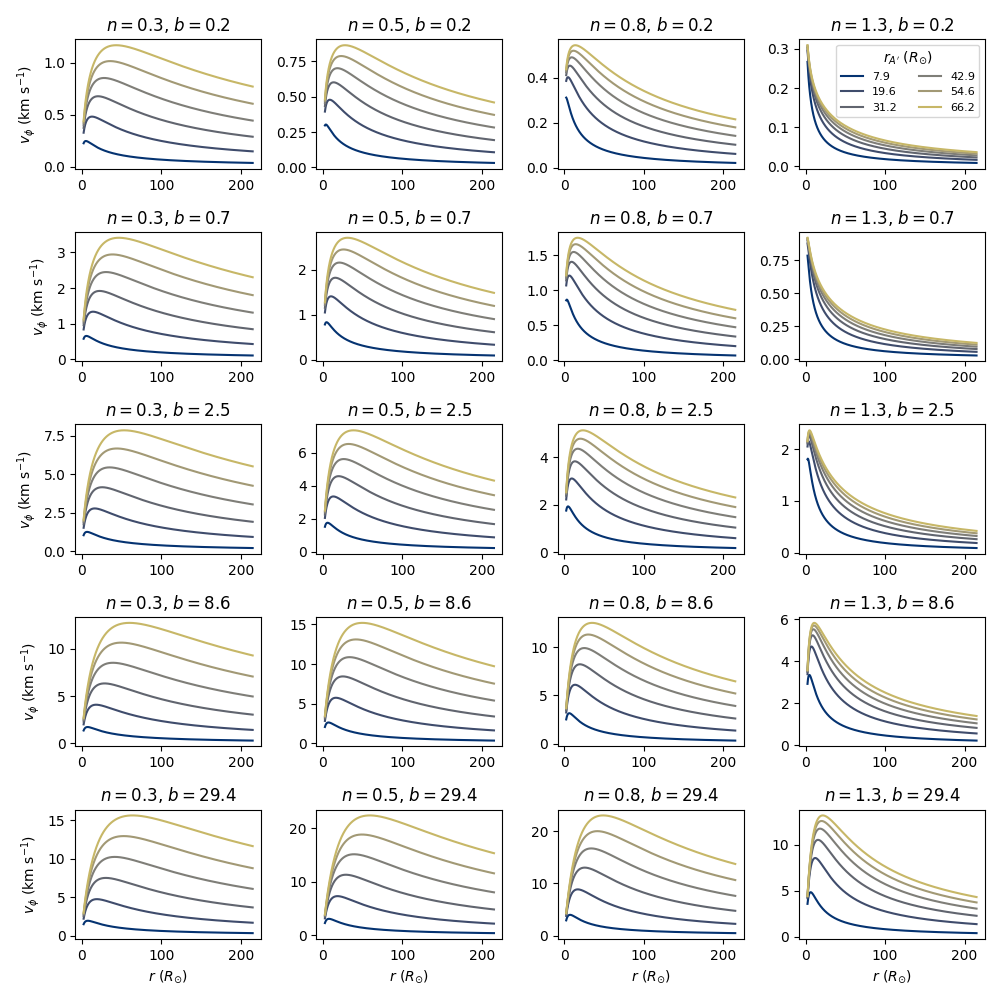

<IPython.core.display.Javascript object>


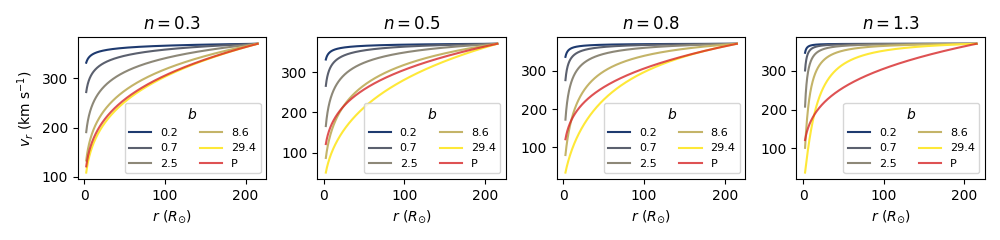

In [29]:
# some more example vr and vphi plots

plt.figure(figsize = (10,10))
k=1
cmap= plt.get_cmap('cividis')
b_inds = np.arange(0,b_vals.size)[1::8]+4
n_inds = [0,1,2,4] 

for i,b in zip(b_inds,b_vals[b_inds]):
    for j,n in zip(n_inds,n_vals[n_inds]):
        plt.subplot(5,4,k)
        a = a_calc(370*u.km/u.s,215*u.R_sun,b,n)
        v_r = asymp(r.value,a,b,n)
        for r_a in r_a_vals[1::4]:
            v_a_point = asymp(r_a.value,a,b,n)
            v_phi = wd_calc_eq10(r,v_r,r_a,v_a_point)
            plt.plot(r,v_phi,color = cmap(.9*r_a/np.max(r_a_vals)),label=f'{r_a.value:.1f}')
        plt.title(f'$n = ${n:.1f}, $b = ${b:.1f}')
        if k % 4 ==1:
            plt.ylabel('$v_{\phi}$ (km s$^{-1}$)')
        if k > 16:
            plt.xlabel('$r$ ($R_{\odot}$)')
        if k == 4:
            plt.legend(title = "$r_{A'}$ ($R_{\odot}$)",fontsize=8,ncol=2)
        k+=1
plt.tight_layout()

plt.savefig('vphi_examples.pdf')

plt.figure(figsize=(10,2.4))

k=1
for j,n in zip(n_inds,n_vals[n_inds]):
    plt.subplot(1,4,k)
    for i,b in zip(b_inds,b_vals[b_inds]):
        a = a_calc(370*u.km/u.s,215*u.R_sun,b,n)
        v_r = asymp(r.value,a,b,n)
        plt.plot(r,v_r,color = cmap(i/np.max(b_inds)),label=f'{b:.1f}')
    plt.plot(r, parker_acc(r.value,370,215),label='P',color='C3',alpha=.8)
    plt.legend(title = "$b$",fontsize=8,ncol=2)
    if k==1: plt.ylabel('$v_r$ (km s$^{-1}$)')
    plt.xlabel('$r$ ($R_{\odot}$)')
    plt.title(f'$n = ${n:.1f}')
    k+=1
plt.tight_layout()

# plt.savefig('vr_examples.pdf')


<IPython.core.display.Javascript object>


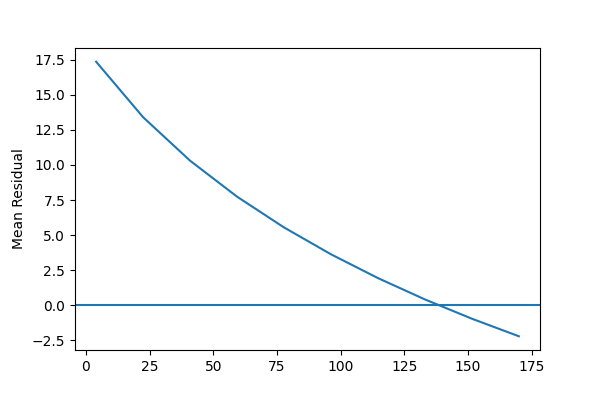

In [30]:
# Plot to find the RA for the parker acceleration profile

r = np.linspace(2.5,215,200)*u.R_sun
r_a_vals = np.linspace(4,170.,10)*u.R_sun
dphi_2d_array = np.zeros([r_a_vals.size,test_df.V.size] )
vphi_store =np.zeros([r_a_vals.size,r.size] )
cut = 214

for i,r_a_val in enumerate(r_a_vals):
    for l,(index,row) in enumerate(test_df.iterrows()):
        v_profile = parker_acc(r.value,row.V*u.km/u.s,215)
        v_point = parker_acc(r_a_val.value,row.V*u.km/u.s,215 )
        v_a_point = v_point*1.
        vphi = wd_calc_eq10(r,v_profile,r_a_val,v_a_point)
        vphi_store[i] = vphi.value

        dphi_2d_array[i,l] = wd_rotation_delta(vphi,v_profile,r,wd_limit=cut).value
        
        

dphi_res_mean_parker = np.zeros([r_a_vals.size])
dphi_residual=None
for i,r_a_val in enumerate(r_a_vals):
    dphi_residual_parker =  dphi_2d_array[i,:] - test_df.lon_shift.values[np.newaxis,:]
    dphi_res_mean_parker[i] = np.nanmean((dphi_residual_parker))

plt.figure()
plt.plot(r_a_vals,dphi_res_mean_parker,label='Parker')
plt.ylabel('Mean Residual')
plt.axhline(0)


<IPython.core.display.Javascript object>


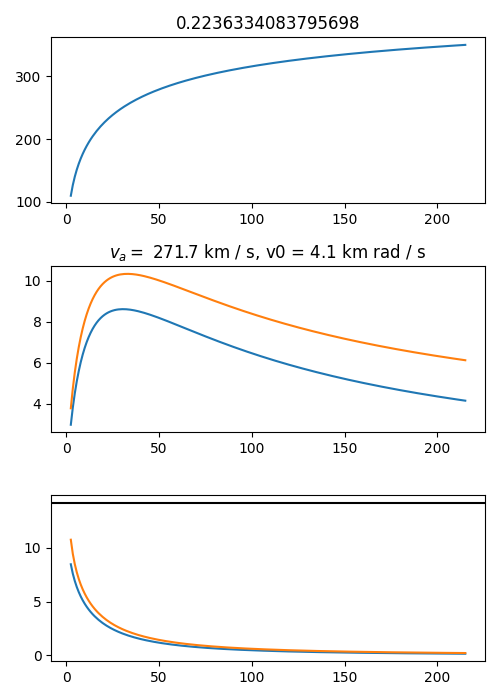

In [31]:
# experiment how to scale v_phi

r_a_val =44*u.R_sun

cut = 214
v0 = 350
b = 5
n =.55
a = a_calc(v0,215*u.R_sun,b,n)
r = np.linspace(2.5,215,200)*u.R_sun

v_profile = asymp(r.value,a,b,n)*u.km/u.s
v_con = v0*np.ones(v_profile.size)*u.km/u.s
v_point = asymp(r_a_val.value,a,b,n)*u.km/u.s
v_a_point = v_point*1.
v_a_use = alfven_scale_wd(r,v_profile,r_a_val,v_a_point)

vphi = wd_calc_eq10(r,v_profile,r_a_val,v_a_point)

scaler =.4

vphi_scaled = vphi_scale(r,vphi,scaler)
om_scaled = (vphi_scaled/r).to(u.deg/u.day)

plt.figure(figsize= (5,7))
plt.subplot(311)
plt.title(f'{1-v_a_point/(v0*u.km/u.s)}')
plt.plot(r,v_profile)
plt.subplot(312)
plt.plot(r,vphi)
plt.plot(r,vphi_scaled)
plt.title(f'$v_a =$ {v_a_point:.1f}, v0 = {vphi[-1]:.1f}')
plt.subplot(313)
plt.plot(r,(vphi/r).to(u.deg/u.day))
plt.plot(r,om_scaled)
plt.axhline((con.get('sidereal rotation rate').to(u.deg/u.day)).value,color='k' )

plt.tight_layout()


<IPython.core.display.Javascript object>


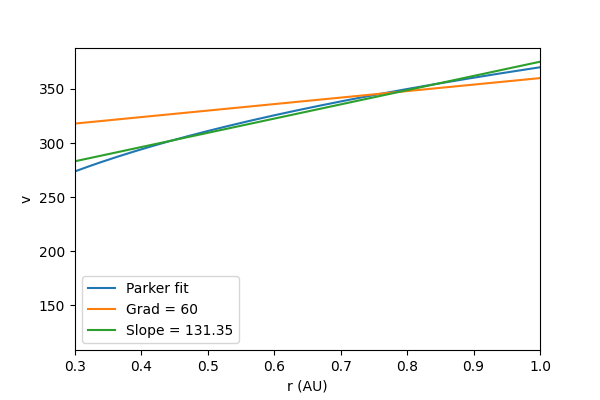

In [32]:
# a quick fit to part of the parker profile to find the gradient.
v_profile = parker_acc(r.value,370,215)

from scipy import stats

res = stats.linregress((r/r[-1])[62:], v_profile[62:])

plt.figure()
plt.plot(r/r[-1],v_profile,label = 'Parker fit')
plt.plot(r/r[-1], 60*r/r[-1] + 300,label = 'Grad = 60')
plt.plot(r/r[-1],res.slope*r/r[-1] + res.intercept,label =f'Slope = {res.slope:.2f}')
plt.xlim(.3,1)
plt.ylabel('v')
plt.xlabel('r (AU)')
plt.legend()